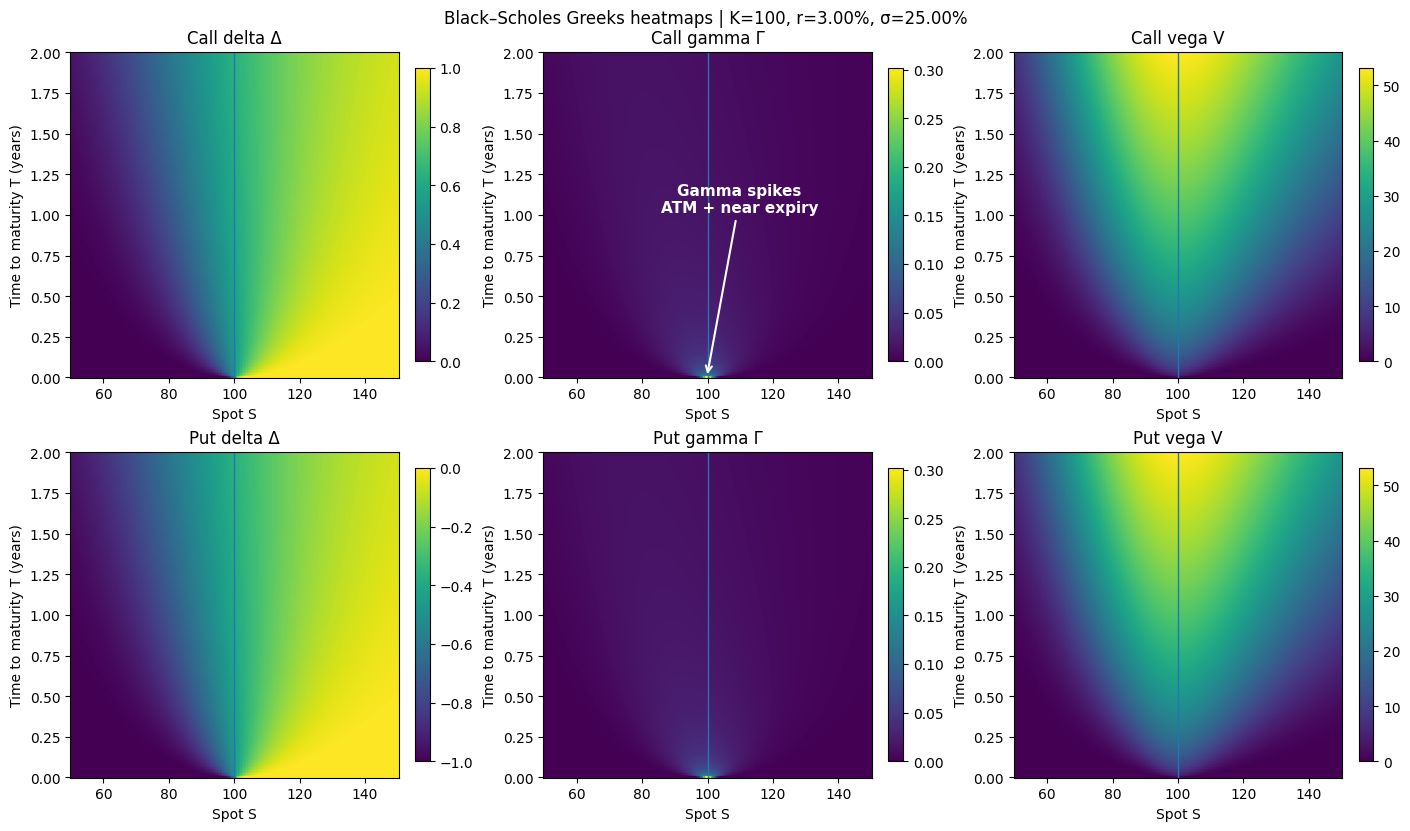

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# I’m using scipy’s normal CDF/PDF because it’s standard, accurate, and saves me from writing my own approximations.

def bs_greeks(S, K, r, sigma, T, is_call=True):
    # I clamp T away from 0 so I can include "near expiry" without dividing by zero.
    T = np.maximum(T, 1e-8)

    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    disc = np.exp(-r * T)
    Nd1, Nd2 = norm.cdf(d1), norm.cdf(d2)
    nd1 = norm.pdf(d1)

    if is_call:
        price = S * Nd1 - K * disc * Nd2
        delta = Nd1
    else:
        price = K * disc * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = Nd1 - 1.0

    gamma = nd1 / (S * sigma * sqrtT)
    vega  = S * nd1 * sqrtT  # this is per +1.00 change in sigma (divide by 100 for “per 1 vol point”)

    return price, delta, gamma, vega


# parameters
K = 100.0
r = 0.03
sigma = 0.25

# grid over spot S and maturity T
S = np.linspace(0.5 * K, 1.5 * K, 220)
T = np.linspace(1/365, 2.0, 220)   # from ~1 day to 2 years
SS, TT = np.meshgrid(S, T)         # rows = T, cols = S (easy to plot)

cP, cD, cG, cV = bs_greeks(SS, K, r, sigma, TT, is_call=True)
pP, pD, pG, pV = bs_greeks(SS, K, r, sigma, TT, is_call=False)


def heat(ax, Z, title):
    # I use a heatmap because it’s the fastest way to see patterns over (S, T).
    im = ax.pcolormesh(S, T, Z, shading="auto")
    ax.set_title(title)
    ax.set_xlabel("Spot S")
    ax.set_ylabel("Time to maturity T (years)")
    ax.axvline(K, lw=1)  # I draw the strike to see “ATM” across all maturities
    plt.colorbar(im, ax=ax, shrink=0.9)


fig, ax = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)

heat(ax[0, 0], cD, "Call delta Δ")
heat(ax[0, 1], cG, "Call gamma Γ")
heat(ax[0, 2], cV, "Call vega V")

heat(ax[1, 0], pD, "Put delta Δ")
heat(ax[1, 1], pG, "Put gamma Γ")
heat(ax[1, 2], pV, "Put vega V")

# I annotate the classic intuition: gamma peaks near ATM and near expiry.
atm_i = np.argmin(np.abs(S - K))
ax[0, 1].annotate(
    "Gamma spikes\nATM + near expiry",
    xy=(S[atm_i], T[0]),
    xytext=(S[int(0.60 * (len(S) - 1))], T[int(0.55 * (len(T) - 1))]),
    color="white",
    fontsize=11,
    fontweight="bold",
    ha="center",
    va="center",
    arrowprops=dict(arrowstyle="->", lw=1.5, color="white"),
)

plt.suptitle(f"Black–Scholes Greeks heatmaps | K={K:g}, r={r:.2%}, σ={sigma:.2%}", y=1.02)
plt.show()

